In [1]:
%pwd

'C:\\Users\\moons\\데이콘'

In [2]:
import matplotlib.pyplot as plt

In [83]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image


# from keras import models, layers
# from keras import Input
# from keras.models import Model, load_model
# from keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers, initializers, regularizers, metrics
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, ZeroPadding2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1/ 255.0,  #값을 0과 1사이로 정규화 -> 데이터가 처음에 들어올 때 이미지는 0~255의 사이의 값으로 들어옴
    rotation_range=30, #무작위 회전각도 30도 이내
    width_shift_range=30, 
    height_shift_range=0.1,
    shear_range=0.1, #층 밀리기 강도 20%   ???
    zoom_range=0.3, #무작위 줌 범위 20%  -> 질문 데이터 사이즈 지정하면 원래 크기인 32by32를 크기 조정하는 것이라고 했는데
    # zoom_range를 이용해서도 크기조정을 하니 데이터 사이즈 지정은 오히려 자유롭게 해도 되는 것인가?
    horizontal_flip=True, #무작위로 가로로 뒤집음
    fill_mode='nearest',
    validation_split=0.2) # set validation split

# 이미지 가로 세로 size 지정, 배치사이즈 지정

In [42]:
train_data_dir = 'data/2차/samul_data/train'
img_height = 50
img_width = 50
batch_size = 256

# train data 를 디렉토리에서 받아옴
## train 폴더 안에 있는 디렉토리 이름이 class로 자동으로 들어감

In [43]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

Found 40000 images belonging to 10 classes.


In [44]:
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 10000 images belonging to 10 classes.


In [45]:
x_train, y_train = train_generator.next()
#next 할 떄마다 한 batch 씩 들어간다고 보면 된다.

In [46]:
x_train.shape
#256의 batch size, 에 100,100의 이미지 사이즈,   3 -> RGB

(256, 50, 50, 3)

In [47]:
y_train[0] 
#NEXT로 한 batch 만 큼 들어갔

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

# 데이터가 제대로 들어갔는 지 확인

(50, 50, 3)


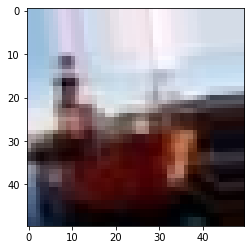

In [48]:
print(x_train[200].shape)
plt.imshow(x_train[0])
plt.show()

In [ ]:
#batch normalization -> 각 레이어마다 input 값들의 분포가 달라

# resnet 손코딩

In [70]:
input_tensor = Input(shape=(50, 50, 3),dtype = 'float', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(10, activation='softmax')(x)
 
resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 56, 56, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_312 (Conv2D)             (None, 25, 25, 64)   9472        zero_padding2d_14[0][0]          
__________________________________________________________________________________________________
batch_normalization_271 (BatchN (None, 25, 25, 64)   256         conv2d_312[0][0]                 
____________________________________________________________________________________________

In [72]:
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 56, 56, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_312 (Conv2D)             (None, 25, 25, 64)   9472        zero_padding2d_14[0][0]          
__________________________________________________________________________________________________
batch_normalization_271 (BatchN (None, 25, 25, 64)   256         conv2d_312[0][0]                 
____________________________________________________________________________________________

In [ ]:
resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [49]:


# with tf.device('/GPU:0'):
#     model = Sequential([
#         Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 3)),
#         MaxPooling2D(2, 2),
#         Conv2D(32, (3, 3), activation='relu',padding='same'),
#         MaxPooling2D(2, 2),
#         Conv2D(64, (3, 3), activation='relu',padding='same'),
#         MaxPooling2D(2, 2),
#         Conv2D(64, (3, 3), activation='relu',padding='same'),
#         MaxPooling2D(2, 2),
#         Conv2D(128, (3, 3), activation='relu',padding='same'),
#         MaxPooling2D(2, 2),
#         Flatten(),
#         Dropout(0.5),
#         Dense(128, activation='relu'),
#         Dense(32, activation='relu'),
#         Dense(10, activation='softmax')
#     ])

# model.summary()

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 6, 6, 64)         

# 임시로 만들어놓았던 간단한 cnn 코드로 fitting

In [50]:
checkpoint_path = "check_samul.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

model.fit(train_generator, 
          validation_data=(validation_generator),
          epochs=5,
          callbacks=[checkpoint],
          )

model.load_weights(checkpoint_path)

model.evaluate(validation_generator)

Epoch 1/5
157/157 [==============================] - 49s 310ms/step - loss: 2.0985 - acc: 0.2034 - val_loss: 1.9176 - val_acc: 0.2806

Epoch 00001: val_loss improved from inf to 1.91764, saving model to check_samul.ckpt
Epoch 2/5
157/157 [==============================] - 49s 310ms/step - loss: 1.8795 - acc: 0.3009 - val_loss: 1.7691 - val_acc: 0.3475

Epoch 00002: val_loss improved from 1.91764 to 1.76914, saving model to check_samul.ckpt
Epoch 3/5
157/157 [==============================] - 49s 311ms/step - loss: 1.7551 - acc: 0.3544 - val_loss: 1.6454 - val_acc: 0.3992

Epoch 00003: val_loss improved from 1.76914 to 1.64537, saving model to check_samul.ckpt
Epoch 4/5
157/157 [==============================] - 46s 294ms/step - loss: 1.6831 - acc: 0.3870 - val_loss: 1.6171 - val_acc: 0.4046

Epoch 00004: val_loss improved from 1.64537 to 1.61706, saving model to check_samul.ckpt
Epoch 5/5
157/157 [==============================] - 47s 301ms/step - loss: 1.6145 - acc: 0.4133 - val_loss:

[1.5403934717178345, 0.4465999901294708]

# resnet 으로 fitting 하여 cnn 간단한 코드와 비교

In [80]:
checkpoint_path_resnet = "check_samul_resnet.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path_resnet, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_acc', 
                             verbose=1)

resnet50.fit(train_generator, 
          validation_data=(validation_generator),
          epochs=100,
          callbacks=[checkpoint],
          )

Epoch 1/100
157/157 [==============================] - 47s 300ms/step - loss: 1.1714 - acc: 0.5908 - val_loss: 1.4870 - val_acc: 0.4963

Epoch 00001: val_acc improved from -inf to 0.49630, saving model to check_samul_resnet.ckpt
Epoch 2/100
157/157 [==============================] - 48s 306ms/step - loss: 1.1269 - acc: 0.6039 - val_loss: 1.5865 - val_acc: 0.4669

Epoch 00002: val_acc did not improve from 0.49630
Epoch 3/100
157/157 [==============================] - 49s 308ms/step - loss: 1.1005 - acc: 0.6119 - val_loss: 1.5759 - val_acc: 0.4989

Epoch 00003: val_acc improved from 0.49630 to 0.49890, saving model to check_samul_resnet.ckpt
Epoch 4/100
157/157 [==============================] - 46s 293ms/step - loss: 1.0824 - acc: 0.6196 - val_loss: 1.7018 - val_acc: 0.4881

Epoch 00004: val_acc did not improve from 0.49890
Epoch 5/100
157/157 [==============================] - 46s 293ms/step - loss: 1.0912 - acc: 0.6238 - val_loss: 1.9393 - val_acc: 0.3648

Epoch 00005: val_acc did not

In [82]:
resnet50.load_weights(checkpoint_path_resnet)

resnet50.evaluate(validation_generator)

40/40 [==============================] - 10s 244ms/step - loss: 0.7560 - acc: 0.7478


[0.7559830546379089, 0.7477999925613403]

In [124]:
test_data_dir = 'data/2차/samul_data/test'
test_datagen = ImageDataGenerator(rescale=1/255.0)

# test 데이터를 불러옴 (test data는 하위 디렉토리가 존재 하지 않고 이미지만 존재하므로 classes=[','] 을 이용하여 이미지만 불러옴
## 여기서 ['.']안의 값으로 데이터를 인식하기 때문에 하위 디렉토리가 따로 인식되지 않음

In [156]:
test_generator = test_datagen.flow_from_directory(test_data_dir,
    # only read images from `test` directory
    classes=['.'],
    # don't generate labels
    class_mode=None,
    # don't shuffle
    shuffle=False,
    # use same size as in training
    target_size=(img_height, img_width))

Found 10000 images belonging to 1 classes.


In [157]:
preds = resnet50.predict_generator(test_generator)

C:\Users\moons\anaconda3\envs\dacon_re\lib\site-packages\tensorflow\python\keras\engine\training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [158]:
preds.shape

(10000, 10)

# 제출 할 수 있는 형태로 DataFrame 생성하기

In [140]:
import pandas as pd

In [142]:
sample=pd.read_csv('data/2차/samul_data/sample_submission.csv')

In [148]:
sample.head()

,id,target
0,0000.jpg,human
1,0001.jpg,human
2,0002.jpg,human
3,0003.jpg,human
4,0004.jpg,human


# argmax -> 값이 최대인 index값을 뱉어냄

In [213]:
class_real=preds.argmax(axis=-1)
#onehot 으로 나온 predict 값을 class 숫자 값으로 만들기

In [214]:
class_real

array([7, 0, 0, ..., 4, 1, 2], dtype=int64)

In [167]:
label_map = (train_generator.class_indices)
#label 이름 추출하기

In [215]:
label_map

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [192]:
#추출된 label 이름과 class 숫자 값을 매핑 하기
class_list = []

for i in range(0,len(class_real)):
    for j in label_map.keys():

        if (class_real[i] == label_map[j]) :
            class_list.append(j)

In [207]:
sample['target']=pd.DataFrame(class_list,columns = ['target'] ).iloc[:,0]

In [212]:
sample.to_csv('samul_first_output.csv', index=False)